In [1]:
!pip install --upgrade xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.1/472.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24


In [2]:
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.2 MB/s eta 0:00:00


In [3]:
!pip install -U geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3


In [4]:
import ee
import xarray as xr
import geemap

In [5]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-my-marv',
     opt_url='https://earthengine-highvolume.googleapis.com'
)

In [6]:
start_date = ee.Date('2020')
end_Date = ee.Date('2021')
time_diff = ee.Number(end_Date.difference(start_date, 'month')).round()
month_list = ee.List.sequence(0, time_diff.subtract(1)).map(lambda x : start_date.advance(x, 'month'))
month_list

In [7]:
import geemap

In [8]:
map = geemap.Map()
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [10]:
geometry = map.draw_last_feature.geometry()
geometry

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          44.208719,
                          24.686229
                        ],
                        [
                          44.208719,
                          39.571209
                        ],
                        [
                          63.368875,
                          39.571209
                        ],
                        [
                          63.368875,
                          24.686229
                        ],
                        [
                          44.208719,
                          24.686229
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [11]:
aod = (
    ee.ImageCollection("MODIS/061/MCD19A2_GRANULES")
    .filterDate(start_date, end_Date)
    .select(['Optical_Depth_055'],['aod'])
    .filter(ee.Filter.eq('SATELLITE','T'))
    .filterBounds(geometry)

)

aod.limit(20)

In [12]:
#creating a list of months
def monthly(date, col):
  start_date = ee.Date(date)
  end_date =start_date.advance(1, 'month')
  col_img = col.filter(ee.Filter.date(start_date, end_date)).mean()
  col_size = ee.Number(col_img.bandNames().size())
  return col_img.set('system:time_start', start_date.millis()).set('bandsize', col_size)


In [13]:
#monthly aod
monthly_aod = ee.ImageCollection(
    month_list.map(lambda x : monthly(x, aod))
)

monthly_aod

In [14]:

terra =  (
    ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
    .filterDate(start_date, end_Date)
    .filterBounds(geometry)
    .select('pr','soil', 'vs', 'tmmn', 'tmmx')
)
terra

In [15]:
#monthly terra
monthly_terra = ee.ImageCollection(
    month_list.map(lambda x : monthly(x, terra))
)
monthly_terra

In [16]:
ndvi = (
    ee.ImageCollection("MODIS/MOD09GA_006_NDVI")
    .filterDate(start_date, end_Date)
    .filterBounds(geometry)
    .select(['NDVI'], ['ndvi'])
)
ndvi

In [17]:
#monthly ndvi
monthly_ndvi = (ee.ImageCollection(month_list.map(
    lambda x : monthly(x, ndvi)
)))
monthly_ndvi

In [19]:
#combining all the variables into a single collection
collection = monthly_aod.combine(monthly_terra).combine(monthly_ndvi)
collection

In [20]:
#opening the collection using xarray to work with python directly
ds = xr.open_dataset(
    collection,
    engine = 'ee',
    crs = 'EPSG: 4326',
    geometry = geometry,
    scale = 0.1
)
ds

<xarray.Dataset> Size: 10MB
Dimensions:  (time: 12, lon: 192, lat: 149)
Coordinates:
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-10-01
  * lon      (lon) float64 2kB 44.26 44.36 44.46 44.56 ... 63.16 63.26 63.36
  * lat      (lat) float64 1kB 24.74 24.84 24.94 25.04 ... 39.34 39.44 39.54
Data variables:
    aod      (time, lon, lat) float32 1MB ...
    pr       (time, lon, lat) float32 1MB ...
    soil     (time, lon, lat) float32 1MB ...
    vs       (time, lon, lat) float32 1MB ...
    tmmn     (time, lon, lat) float32 1MB ...
    tmmx     (time, lon, lat) float32 1MB ...
    ndvi     (time, lon, lat) float32 1MB ...
Attributes:
    crs:      EPSG: 4326

In [21]:
ds = ds.sortby('time')* 1
ds

<xarray.Dataset> Size: 10MB
Dimensions:  (time: 12, lon: 192, lat: 149)
Coordinates:
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
  * lon      (lon) float64 2kB 44.26 44.36 44.46 44.56 ... 63.16 63.26 63.36
  * lat      (lat) float64 1kB 24.74 24.84 24.94 25.04 ... 39.34 39.44 39.54
Data variables:
    aod      (time, lon, lat) float32 1MB 116.8 109.8 101.5 ... 162.6 162.7
    pr       (time, lon, lat) float32 1MB 1.0 1.0 1.0 1.0 ... 6.0 5.0 5.0 5.0
    soil     (time, lon, lat) float32 1MB 8.0 9.0 9.0 9.0 ... 5.0 3.0 3.0 2.0
    vs       (time, lon, lat) float32 1MB 293.0 303.0 323.0 ... 213.0 220.0
    tmmn     (time, lon, lat) float32 1MB 72.0 73.0 73.0 ... -63.0 -66.0 -64.0
    tmmx     (time, lon, lat) float32 1MB 196.0 195.0 196.0 ... 34.0 31.0 32.0
    ndvi     (time, lon, lat) float32 1MB 0.07339 0.06839 ... 0.05037 0.05105
Attributes:
    crs:      EPSG: 4326

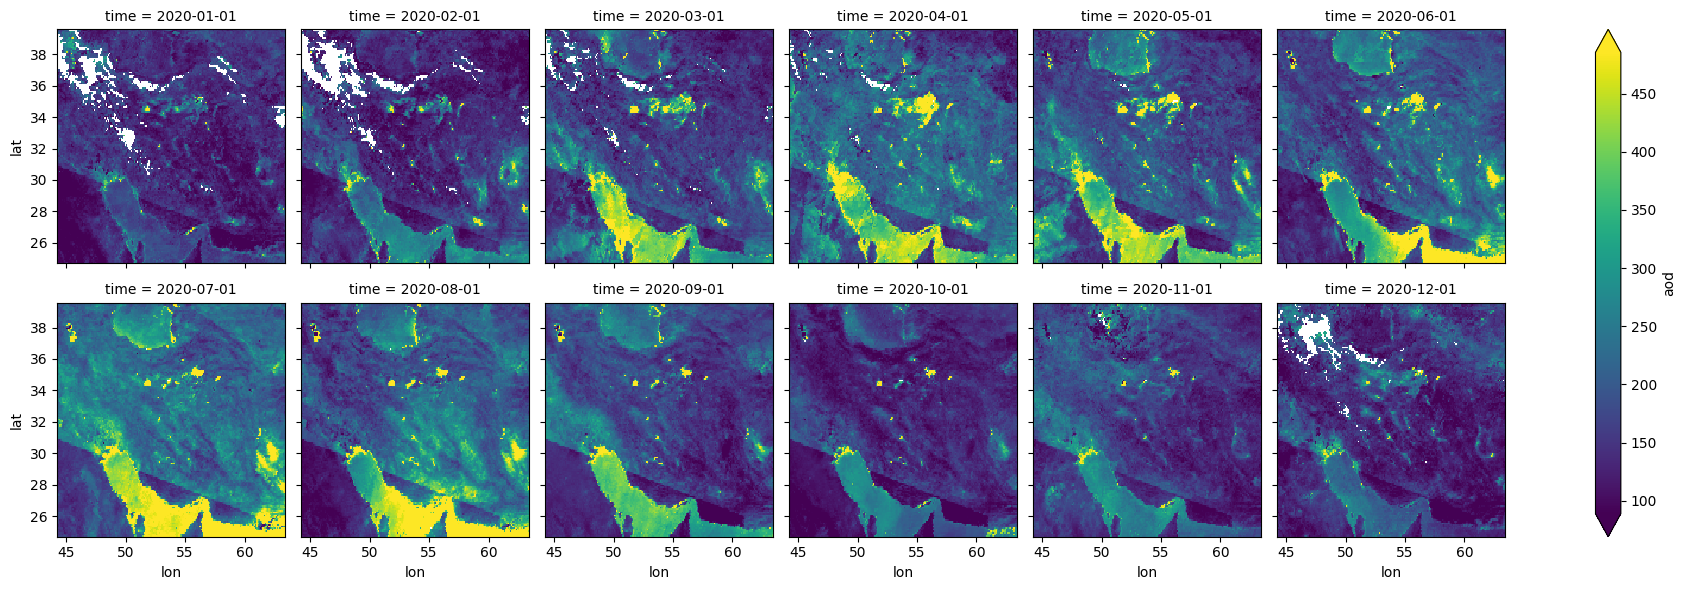

In [22]:
ds.aod.plot(
    x= 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 6,
    robust = True
)

In [23]:
#loading the water mask
mask = (
    ee.ImageCollection("MODIS/061/MCD12Q1")
    .filterDate(start_date, end_Date)
    .filterBounds(geometry)
    .select('LC_Type1')
    .mode().eq(17).Not().rename('water_mask')
)
mask

In [24]:
ds_mask = xr.open_dataset(
    mask,
    engine = 'ee',
    crs = 'EPSG:4326',
    geometry =geometry,
    scale = 0.1
)

ds_mask

<xarray.Dataset> Size: 117kB
Dimensions:     (time: 1, lon: 192, lat: 149)
Coordinates:
  * time        (time) int64 8B 0
  * lon         (lon) float64 2kB 44.26 44.36 44.46 44.56 ... 63.16 63.26 63.36
  * lat         (lat) float64 1kB 24.74 24.84 24.94 25.04 ... 39.34 39.44 39.54
Data variables:
    water_mask  (time, lon, lat) float32 114kB ...
Attributes:
    crs:      EPSG:4326

In [25]:
ds_mask = ds_mask.squeeze('time').drop_vars('time') * 1
ds_mask

<xarray.Dataset> Size: 117kB
Dimensions:     (lon: 192, lat: 149)
Coordinates:
  * lon         (lon) float64 2kB 44.26 44.36 44.46 44.56 ... 63.16 63.26 63.36
  * lat         (lat) float64 1kB 24.74 24.84 24.94 25.04 ... 39.34 39.44 39.54
Data variables:
    water_mask  (lon, lat) float32 114kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:4326

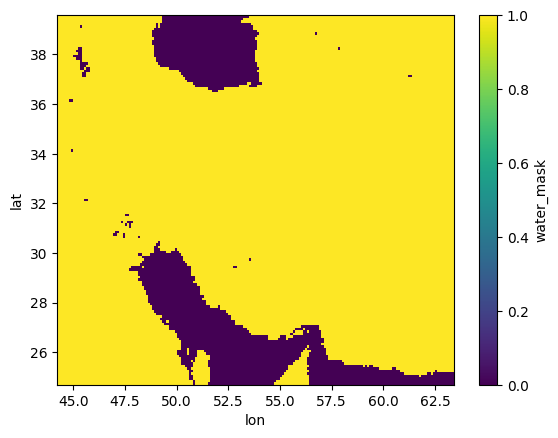

In [27]:
ds_mask.water_mask.plot(
    x= 'lon',
    y = 'lat'
)


In [28]:
import numpy as np

In [29]:
#masking out the water pixels from the ds collection
ds = xr.where(ds_mask.water_mask == 0 , np.nan, ds)

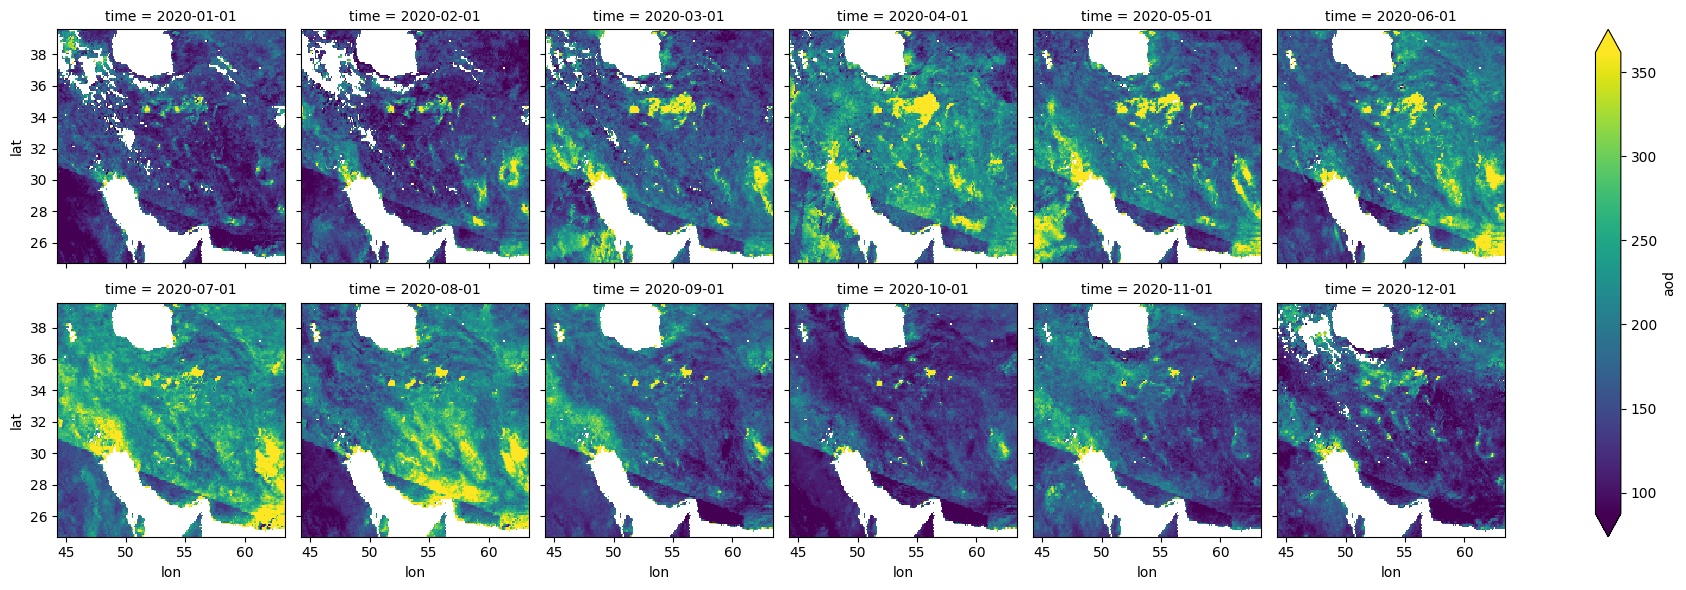

In [30]:
ds.aod.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 6,
    robust = True

)

In [31]:
#creating a new variable dust
#dust occurs in areas where aod >= 0.5
ds['Dust'] = ((ds.aod * 0.001) >= 0.5).astype(int)
ds

<xarray.Dataset> Size: 12MB
Dimensions:  (lon: 192, lat: 149, time: 12)
Coordinates:
  * lon      (lon) float64 2kB 44.26 44.36 44.46 44.56 ... 63.16 63.26 63.36
  * lat      (lat) float64 1kB 24.74 24.84 24.94 25.04 ... 39.34 39.44 39.54
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
Data variables:
    aod      (lon, lat, time) float32 1MB 116.8 138.4 149.2 ... 130.5 162.7
    pr       (lon, lat, time) float32 1MB 1.0 1.0 3.0 44.0 ... 0.0 0.0 3.0 5.0
    soil     (lon, lat, time) float32 1MB 8.0 8.0 8.0 7.0 ... 2.0 2.0 2.0 2.0
    vs       (lon, lat, time) float32 1MB 293.0 340.0 360.0 ... 270.0 220.0
    tmmn     (lon, lat, time) float32 1MB 72.0 110.0 141.0 ... 58.0 -15.0 -64.0
    tmmx     (lon, lat, time) float32 1MB 196.0 249.0 287.0 ... 221.0 114.0 32.0
    ndvi     (lon, lat, time) float32 1MB 0.07339 0.06886 ... 0.07614 0.05105
    Dust     (lon, lat, time) int64 3MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

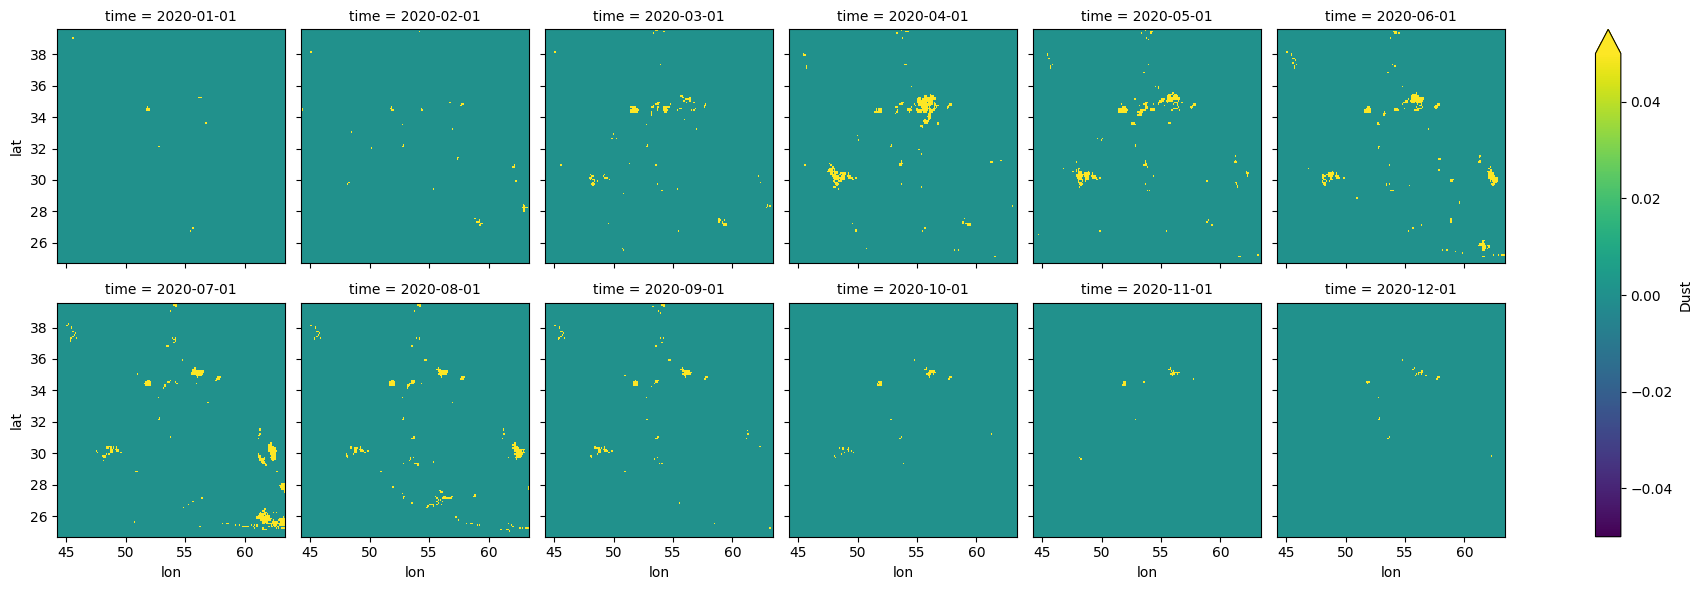

In [32]:
ds.Dust.plot(
    x = 'lon',
    y= 'lat',
    col = 'time',
    col_wrap = 6,
    robust = True
)

In [33]:
#importing machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [38]:
#convert the ds to a dataframe
df = ds.to_dataframe().dropna()
df

aod    pr  soil     vs   tmmn   tmmx  \
lon       lat       time                                                      
44.258719 24.736229 2020-01-01  116.777779   1.0   8.0  293.0   72.0  196.0   
                    2020-02-01  138.437500   1.0   8.0  340.0  110.0  249.0   
                    2020-03-01  149.250000   3.0   8.0  360.0  141.0  287.0   
                    2020-04-01  138.583328  44.0   7.0  420.0  187.0  336.0   
                    2020-05-01  375.799988   6.0   7.0  348.0  241.0  395.0   
...                                    ...   ...   ...    ...    ...    ...   
63.358719 39.536229 2020-08-01  162.333328   0.0   2.0  220.0  205.0  373.0   
                    2020-09-01  134.718750   0.0   2.0  278.0  120.0  296.0   
                    2020-10-01  149.757568   0.0   2.0  290.0   58.0  221.0   
                    2020-11-01  130.521744   3.0   2.0  270.0  -15.0  114.0   
                    2020-12-01  162.692307   5.0   2.0  220.0  -64.0   32.0   

                                    ndvi  Dust  
lon       lat       time                        
44.258719 24.736229 2020-01-01  0.073385     0  
                    2020-02-01  0.068859     0  
                    2020-03-01  0.070797     0  
                    2020-04-01  0.071082     0  
                    2020-05-01  0.062972     0  
...                                  ...   ...  
63.358719 39.536229 2020-08-01  0.096583     0  
                    2020-09-01  0.096761     0  
                    2020-10-01  0.097742     0  
                    2020-11-01  0.076144     0  
                    2020-12-01  0.051050     0  

[292753 rows x 8 columns]

In [39]:
#train and test variable
X = df[['ndvi', 'vs', 'soil', 'tmmn', 'tmmx', 'pr']]
y = df[['Dust']]


In [40]:
#splitting training and testing variables
X_train,X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state= 42)

In [41]:
#model fitting
model = LogisticRegression(class_weight="balanced",max_iter= 1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [42]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [44]:
y_score = y_proba[:,1]
y_score.shape

(58551,)

In [49]:
#classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     58146
           1       0.04      0.91      0.08       405

    accuracy                           0.85     58551
   macro avg       0.52      0.88      0.50     58551
weighted avg       0.99      0.85      0.91     58551



In [50]:
#compute the roc AREA UNDER THE CURVE
roc_score = roc_auc_score(y_test, y_score)
print(f"roc_auc_score: {roc_score:.2f}")

roc_auc_score: 0.95


In [51]:
import matplotlib.pyplot as plt


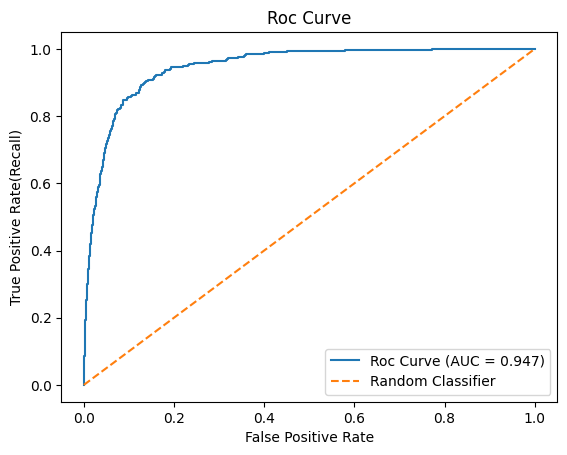

In [81]:
#Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, threshold = roc_curve(y_test, y_score)
#plot the ROC CURVE
plt.figure()
plt.plot(fpr, tpr, label=f"Roc Curve (AUC = {roc_score:.3f})")
plt.plot([0,1], [0,1], linestyle= "--", label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate(Recall)")
plt.title("Roc Curve")
plt.legend()
plt.show()

In [70]:
df['risk'] = model.predict_proba(df[['ndvi', 'vs', 'soil', 'tmmn', 'tmmx', 'pr']])[:,1]
df

aod    pr  soil     vs   tmmn   tmmx  \
lon       lat       time                                                      
44.258719 24.736229 2020-01-01  116.777779   1.0   8.0  293.0   72.0  196.0   
                    2020-02-01  138.437500   1.0   8.0  340.0  110.0  249.0   
                    2020-03-01  149.250000   3.0   8.0  360.0  141.0  287.0   
                    2020-04-01  138.583328  44.0   7.0  420.0  187.0  336.0   
                    2020-05-01  375.799988   6.0   7.0  348.0  241.0  395.0   
...                                    ...   ...   ...    ...    ...    ...   
63.358719 39.536229 2020-08-01  162.333328   0.0   2.0  220.0  205.0  373.0   
                    2020-09-01  134.718750   0.0   2.0  278.0  120.0  296.0   
                    2020-10-01  149.757568   0.0   2.0  290.0   58.0  221.0   
                    2020-11-01  130.521744   3.0   2.0  270.0  -15.0  114.0   
                    2020-12-01  162.692307   5.0   2.0  220.0  -64.0   32.0   

                                    ndvi  Dust      risk  
lon       lat       time                                  
44.258719 24.736229 2020-01-01  0.073385     0  0.111513  
                    2020-02-01  0.068859     0  0.212676  
                    2020-03-01  0.070797     0  0.279637  
                    2020-04-01  0.071082     0  0.439563  
                    2020-05-01  0.062972     0  0.765481  
...                                  ...   ...       ...  
63.358719 39.536229 2020-08-01  0.096583     0  0.349172  
                    2020-09-01  0.096761     0  0.104569  
                    2020-10-01  0.097742     0  0.034695  
                    2020-11-01  0.076144     0  0.030776  
                    2020-12-01  0.051050     0  0.053266  

[292753 rows x 9 columns]

In [72]:
dfx = df.to_xarray().sortby(['time', 'lon', 'lat'])
dfx

<xarray.Dataset> Size: 15MB
Dimensions:  (lon: 192, lat: 149, time: 12)
Coordinates:
  * lon      (lon) float64 2kB 44.26 44.36 44.46 44.56 ... 63.16 63.26 63.36
  * lat      (lat) float64 1kB 24.74 24.84 24.94 25.04 ... 39.34 39.44 39.54
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
Data variables:
    aod      (lon, lat, time) float32 1MB 116.8 138.4 149.2 ... 130.5 162.7
    pr       (lon, lat, time) float32 1MB 1.0 1.0 3.0 44.0 ... 0.0 0.0 3.0 5.0
    soil     (lon, lat, time) float32 1MB 8.0 8.0 8.0 7.0 ... 2.0 2.0 2.0 2.0
    vs       (lon, lat, time) float32 1MB 293.0 340.0 360.0 ... 270.0 220.0
    tmmn     (lon, lat, time) float32 1MB 72.0 110.0 141.0 ... 58.0 -15.0 -64.0
    tmmx     (lon, lat, time) float32 1MB 196.0 249.0 287.0 ... 221.0 114.0 32.0
    ndvi     (lon, lat, time) float32 1MB 0.07339 0.06886 ... 0.07614 0.05105
    Dust     (lon, lat, time) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    risk     (lon, lat, time) float64 3MB 0.1115 0.2127 ... 0.03078 0.05327

In [73]:
risk = (dfx.risk * 1000).mean(dim ='time')

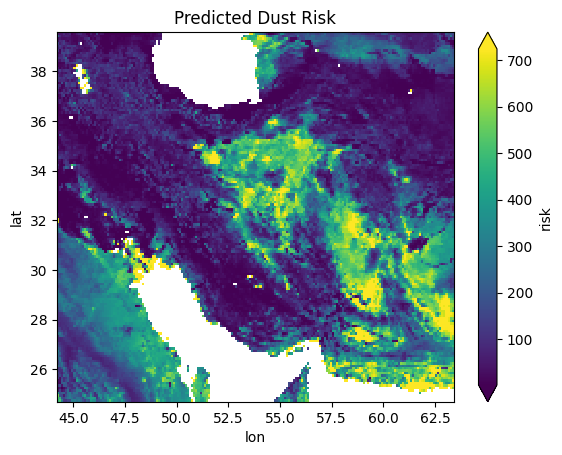

In [77]:
risk.plot(
    x = 'lon',
    y= 'lat',
    robust = True
)
plt.title('Predicted Dust Risk')
plt.show()

<Figure size 1300x1000 with 0 Axes>

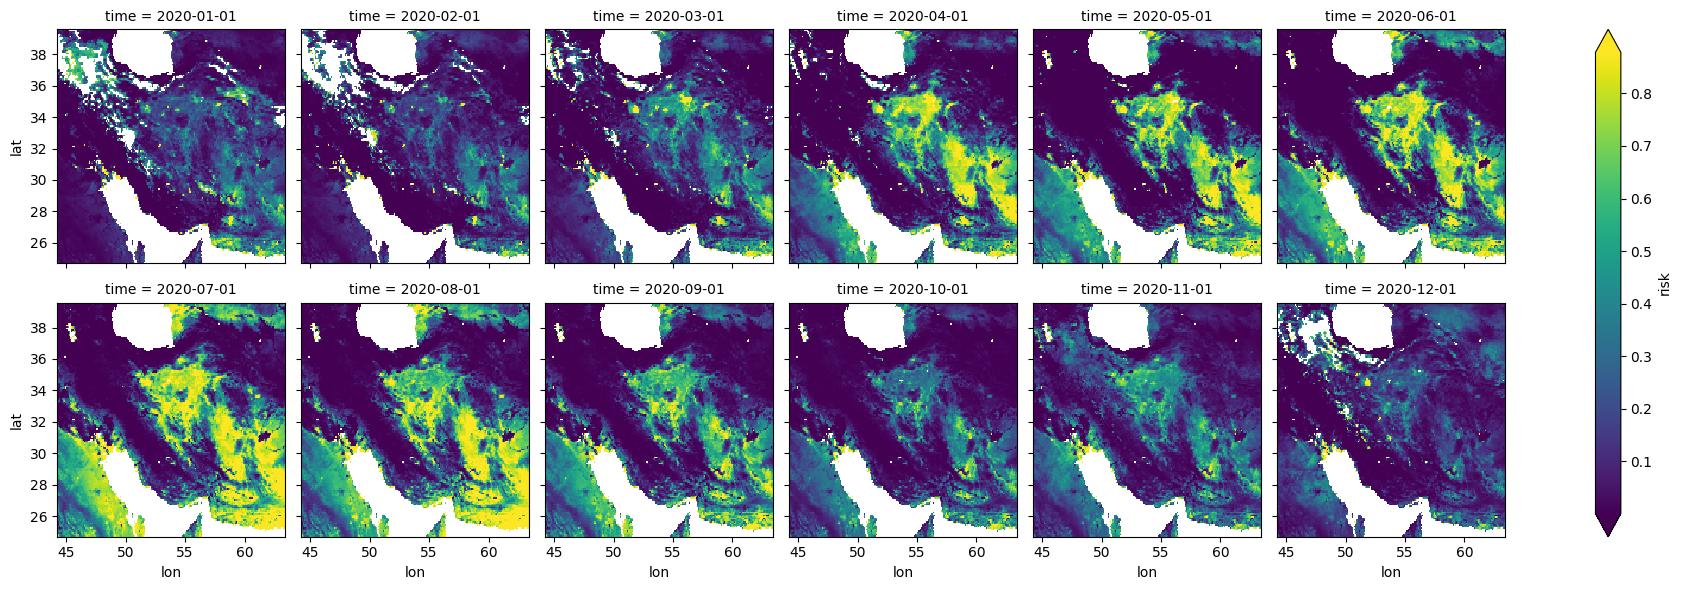

<Figure size 640x480 with 0 Axes>

In [92]:
plt.figure(figsize = (13, 10))


dfx.risk.plot(
    x= 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 6,
    robust = True

)

plt.show()
plt.tight_layout()